In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create an inspector object
inspector = inspect(engine)

# Use the inspector to find the names of the tables in the database
table_names = inspector.get_table_names()

# Iterate over each table to print out its column names and types
for table_name in table_names:
    print(f"Table: {table_name}")
    print("-" * 20)
    columns = inspector.get_columns(table_name)
    for column in columns:
        print(f"Column: {column['name']} | Type: {column['type']}")
    print()

Table: measurement
--------------------
Column: id | Type: INTEGER
Column: station | Type: TEXT
Column: date | Type: TEXT
Column: prcp | Type: FLOAT
Column: tobs | Type: FLOAT

Table: station
--------------------
Column: id | Type: INTEGER
Column: station | Type: TEXT
Column: name | Type: TEXT
Column: latitude | Type: FLOAT
Column: longitude | Type: FLOAT
Column: elevation | Type: FLOAT



In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set - NB- 2016 was a leap year.
one_year_ago = dt.datetime.strptime('2017-08-23', '%Y-%m-%d') - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_index()

#Examine latest data 
df.tail()

,precipitation
date,
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45


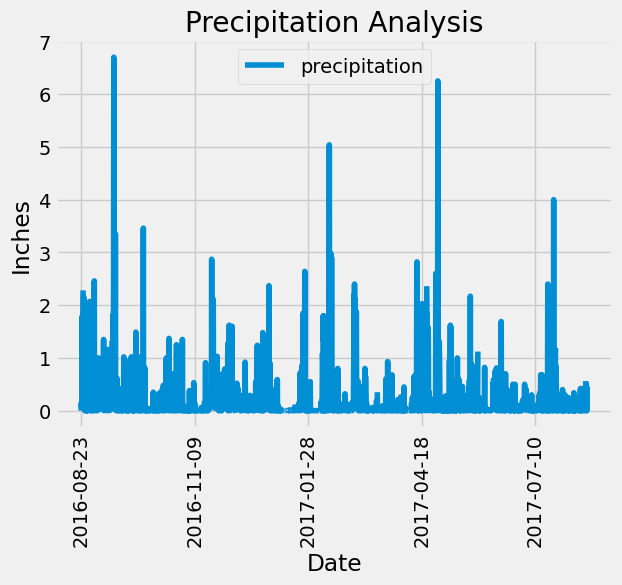

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation Analysis")
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs), 
                                  func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

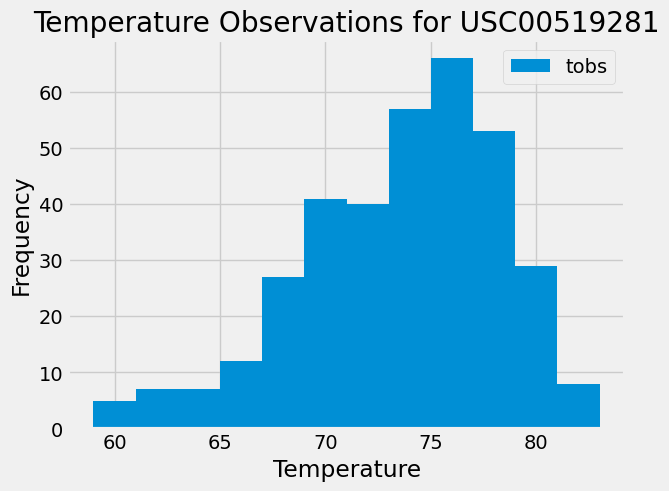

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert to list
tobs_data_list = list(np.ravel(tobs_data))

# Plot the results as a histogram
plt.hist(tobs_data_list, bins=12, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for {most_active_station}')
plt.legend()
plt.show()

# Close Session

In [19]:
# Close Session
session.close()